# Use of weighted binary cross-entropy

Notebook that explores the performance of unweighted vs weighted binary cross-entropy, and what particular weight works best.

In [11]:
# Importing some libraries

# Torch 
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

# Other libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt

**Unpacking the data**

In this first part, some functions are defined to unpack the data.

In [12]:
class CPU_Unpickler(pickle.Unpickler):
    # to avoid errors that occur when loading pickle files on cpu that were originally saved using a gpu
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [13]:
# Function that enables you to unpack a certain chunk of data
def load_chunk_file(file_path, chunk_i):
    with open(file_path+f'chunk_{chunk_i}', 'rb') as file:
            loaded_data = CPU_Unpickler(file).load()
            
    return loaded_data

In [14]:
# The locations of the data
file_path_noisy = '/lustre/fs23/group/cta/users/amehta/summer_student_data/noisy_images/'
file_path_true = '/lustre/fs23/group/cta/users/amehta/summer_student_data/true_images/'

# Unpack 100 chunks of data
chunk_tot = 100

data_noisy_tot = np.array([])
data_true_tot = np.array([])

for chunk_i in range(0,chunk_tot):
    data_noisy_all = load_chunk_file(file_path_noisy, chunk_i)
    mask_gamma_ray = np.array((data_noisy_all[1]==1))
    data_noisy_chunk = np.array(data_noisy_all[0])[mask_gamma_ray]
    data_noisy_tot = np.append(data_noisy_tot, data_noisy_chunk)
    
    data_true_all = load_chunk_file(file_path_true, chunk_i)
    data_true_chunk = np.array(data_true_all[0])[mask_gamma_ray]
    data_true_tot = np.append(data_true_tot, data_true_chunk)
    
# Get it in the right shape
data_noisy = data_noisy_tot.reshape(64*chunk_tot, 56, 56)
data_true = data_true_tot.reshape(64*chunk_tot, 56, 56)


**Data Preperation**

In [15]:
# Make a mask of the locations of the nans, so that we can put them back in after fitting.

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

data_true_binary = np.zeros((64*chunk_tot, 56, 56))
data_true_binary[data_true>threshold] = 1
data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
pix_max = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
pix_min = np.nanmin(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num((data_noisy_arr - pix_min)/(pix_max-pix_min))

data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())
data_noisy_tensor = (torch.from_numpy(data_noisy_nonan[images_high_mask]).float())
data_true_tensor = (torch.from_numpy(data_true_binary_flat[images_high_mask])).float()

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()
data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = data_noisy_tensor[idx_split:]
data_true_test = data_true_tensor[idx_split:]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = data_noisy_tensor_im[idx_split:]
data_true_test_im = data_true_tensor_im[idx_split:]


In [16]:
# Batch form
batch_size = 1

N, H, W = data_noisy_train.shape
N_new = N//batch_size

data_noisy_train_batch = data_noisy_train[:int(N_new*batch_size)].reshape(N_new, batch_size, 1, H, W)
data_true_train_batch = data_true_train[:int(N_new*batch_size)].reshape(N_new, batch_size, H*W)

**The Autoencoder Model**

In [17]:
# AE with 4 layers

class AE4(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 75
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 10, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(10, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
            
        x = F.sigmoid(x)
        
        return x         

**Define functions for the training and the testing**

In [18]:
# Function to calculate the intersection-over-union
def IOU_calc(clean_iou, true_iou): 
    clean_sum = torch.sum(clean_iou)
    true_sum = torch.sum(true_iou)
    true_iou2 = torch.zeros(true_iou.shape)
    
    true_iou2[true_iou==0] = 2 
    true_iou2[true_iou==1] = 1
    
    intersection_arr = (clean_iou==true_iou2)
    intersection_sum = torch.sum(intersection_arr)
    
    IOU = intersection_sum/(clean_sum+true_sum-intersection_sum)
    
    return IOU

In [19]:
learning_rate = 0.0005

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

**Unweighted binary cross entropy**

In [20]:
# This is the main training loop
log_interval = 10
def train(epoch):
    network_u.train()
    i=0
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train, data_true_train):
        noisy = noisy.unsqueeze(0)
        true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network_u(noisy)
        loss = F.cross_entropy(output, true)
        loss.backward()
        optimizer.step()
        train_losses_u.append(loss.item())

# This is the main testing loop
def test():
    network_u.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true in zip(data_noisy_test, data_true_test):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network_u(noisy)
            test_loss += F.cross_entropy(output, true, reduction='sum').item()
            output_binary = output.data.round()
            pred = output.data.max(1, keepdim=True)[1]
            IOU += IOU_calc(output_binary, true)
    
    test_loss /= len(data_noisy_test)
    IOU /= len(data_noisy_test)
    test_losses_u.append(test_loss)
    IOU_list_u.append(IOU)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
    print(f'IOU: {IOU}')

In [21]:
def IOU_calc(clean_iou, true_iou): 
    clean_sum = torch.sum(clean_iou)
    true_sum = torch.sum(true_iou)
    true_iou2 = torch.zeros(true_iou.shape)
    
    true_iou2[true_iou==0] = 2 
    true_iou2[true_iou==1] = 1
    
    intersection_arr = (clean_iou==true_iou2)
    intersection_sum = torch.sum(intersection_arr)
    
    IOU = intersection_sum/(clean_sum+true_sum-intersection_sum)
    
    return IOU

In [22]:
%%time

n_epochs = 15

learning_rate = 0.0005

network_u = AE4()
optimizer = torch.optim.Adam(network_u.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses_u = []
test_losses_u = []
IOU_list_u = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 647.1607
IOU: 0.025002144277095795

Test set: Avg. loss: 593.8826
IOU: 0.20921646058559418

Test set: Avg. loss: 593.1194
IOU: 0.2217026650905609

Test set: Avg. loss: 593.7563
IOU: 0.22181682288646698

Test set: Avg. loss: 596.9571
IOU: 0.13104942440986633

Test set: Avg. loss: 593.3151
IOU: 0.24072881042957306

Test set: Avg. loss: 593.8887
IOU: 0.21470792591571808

Test set: Avg. loss: 595.5133
IOU: 0.19286562502384186

Test set: Avg. loss: 595.7510
IOU: 0.16163107752799988

Test set: Avg. loss: 641.9063
IOU: 0.027377383783459663

Test set: Avg. loss: 641.8971
IOU: 0.02758600376546383

Test set: Avg. loss: 595.7150
IOU: 0.19335123896598816

Test set: Avg. loss: 595.5283
IOU: 0.2694737911224365

Test set: Avg. loss: 615.6223
IOU: 0.3056946098804474

Test set: Avg. loss: 596.1970
IOU: 0.2664358913898468

Test set: Avg. loss: 595.2999
IOU: 0.17268486320972443
CPU times: user 6h 33min 31s, sys: 4min 46s, total: 6h 38min 18s
Wall time: 12min 29s


**Weighted binary cross entropy**

In [23]:
# AE with 4 layers

class AE4(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 75
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 10, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(10, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
            
        
        return x         

In [24]:
# Functions and definitions for 
n_epochs = 3

weight = 2

batch_size = 1

# This is the main training loop
def train(epoch):
    network_w.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train_batch, data_true_train_batch):
        #noisy = noisy.unsqueeze(0)
        #true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network_w(noisy)
        weights = torch.tensor([weight])
        loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch_size
    train_losses_w.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.4f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network_w.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true in zip(data_noisy_test, data_true_test):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network_w(noisy)
            weights = torch.tensor([weight])
            loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
            test_loss += loss.item()
            output_data = F.sigmoid(output.data)
            output_binary = output_data.round()
            pred = output.data.max(1, keepdim=True)[1]
            IOU += IOU_calc(output_binary, true)
    
    test_loss /= len(data_noisy_test)
    IOU /= len(data_noisy_test)
    test_losses_w.append(test_loss)
    IOU_list_w.append(IOU)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
    print(f'IOU: {IOU}')

In [25]:
%%time

n_epochs = 15

learning_rate = 0.0005

network_w = AE4()
optimizer = torch.optim.Adam(network_w.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses_w = []
test_losses_w = []
IOU_list_w = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.8160
IOU: 0.02564774826169014
Training set: Avg. loss: 0.1202

Test set: Avg. loss: 0.0992
IOU: 0.34166181087493896
Training set: Avg. loss: 0.0986

Test set: Avg. loss: 0.0782
IOU: 0.45134925842285156
Training set: Avg. loss: 0.0909

Test set: Avg. loss: 0.0784
IOU: 0.46987995505332947
Training set: Avg. loss: 0.0874

Test set: Avg. loss: 0.0730
IOU: 0.4808364808559418
Training set: Avg. loss: 0.0843

Test set: Avg. loss: 0.0733
IOU: 0.48435935378074646
Training set: Avg. loss: 0.0833

Test set: Avg. loss: 0.0725
IOU: 0.4858720302581787
Training set: Avg. loss: 0.0822

Test set: Avg. loss: 0.0715
IOU: 0.484154611825943
Training set: Avg. loss: 0.0805

Test set: Avg. loss: 0.0725
IOU: 0.48674941062927246
Training set: Avg. loss: 0.0798

Test set: Avg. loss: 0.0718
IOU: 0.490384966135025
Training set: Avg. loss: 0.0788

Test set: Avg. loss: 0.0714
IOU: 0.4894048571586609
Training set: Avg. loss: 0.0786

Test set: Avg. loss: 0.0714
IOU: 0.49203839898109436
Trainin

**Compare unweighted and weighted**

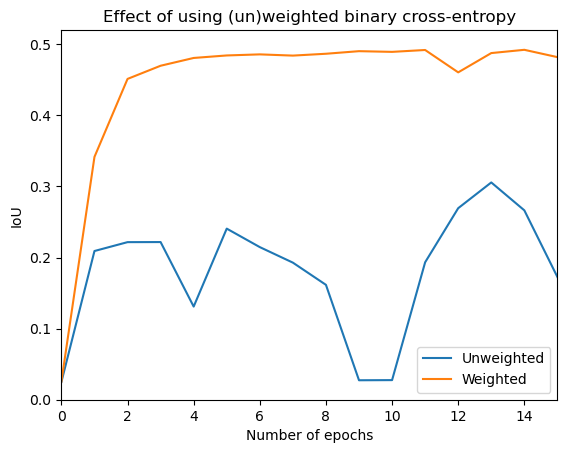

In [30]:
# Plot the fitting results as the loss function and the IoU

fig_weighted = plt.figure()

plt.title("Effect of using (un)weighted binary cross-entropy")
plt.plot(test_counter, IOU_list_u, label='Unweighted')
plt.plot(test_counter, IOU_list_w, label='Weighted')
#plt.hlines(0.4070115627594698, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
plt.xlim(0,n_epochs)
plt.ylim(0,0.52)
plt.xlabel("Number of epochs")
plt.ylabel("IoU")
plt.legend()

plt.show()

fig_weighted.savefig("images/weighted.pdf")

**Compare different weights**

In [31]:
# Functions and definitions for 
n_epochs = 3

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

weight = 2

# This is the main training loop
def train(epoch):
    network.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train_batch, data_true_train_batch):
        #noisy = noisy.unsqueeze(0)
        #true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network(noisy)
        weights = torch.tensor([weight])
        loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch_size
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.4f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true in zip(data_noisy_test, data_true_test):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network(noisy)
            weights = torch.tensor([weight])
            loss = F.binary_cross_entropy_with_logits(output, true, pos_weight=weights)
            test_loss += loss.item()
            output_data = F.sigmoid(output.data)
            #output_binary = torch.zeros((output_data.shape))
            #output_binary[output_data>prob_threshold] = 1
            output_binary = output_data.round()

            pred = output.data.max(1, keepdim=True)[1]
            IOU += IOU_calc(output_binary, true)
    
    test_loss /= len(data_noisy_test)
    IOU /= len(data_noisy_test)
    test_losses.append(test_loss)
    IOU_list.append(IOU)
    print('\nTest set: Avg. loss: {:.4f}'.format(test_loss))
    print(f'IOU: {IOU}')

In [32]:
%%time

IOU_all = []

weight_list = [1,2,3,4,5]

n_epochs = 15

for weight in weight_list:
    weight = weight
    
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*100 for i in range(n_epochs + 1)]
    IOU_list = []

    network = AE4()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

    test()
    for epoch in range(1, n_epochs + 1):
        train(epoch)
        test()
        
    IOU_all.append(IOU_list)
    
IOU_all_arr = np.array(IOU_all)


Test set: Avg. loss: 0.8191
IOU: 0.02353101596236229
Training set: Avg. loss: 0.0978

Test set: Avg. loss: 0.0550
IOU: 0.37534046173095703
Training set: Avg. loss: 0.0628

Test set: Avg. loss: 0.0498
IOU: 0.43006226420402527
Training set: Avg. loss: 0.0582

Test set: Avg. loss: 0.0469
IOU: 0.4495801627635956
Training set: Avg. loss: 0.0552

Test set: Avg. loss: 0.0470
IOU: 0.4543914794921875
Training set: Avg. loss: 0.0538

Test set: Avg. loss: 0.0455
IOU: 0.44353094696998596
Training set: Avg. loss: 0.0527

Test set: Avg. loss: 0.0451
IOU: 0.4741227328777313
Training set: Avg. loss: 0.0518

Test set: Avg. loss: 0.0447
IOU: 0.4767090976238251
Training set: Avg. loss: 0.0513

Test set: Avg. loss: 0.0445
IOU: 0.46744608879089355
Training set: Avg. loss: 0.0506

Test set: Avg. loss: 0.0448
IOU: 0.4641716480255127
Training set: Avg. loss: 0.0502

Test set: Avg. loss: 0.0441
IOU: 0.4774172008037567
Training set: Avg. loss: 0.0498

Test set: Avg. loss: 0.0449
IOU: 0.46201440691947937
Traini

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


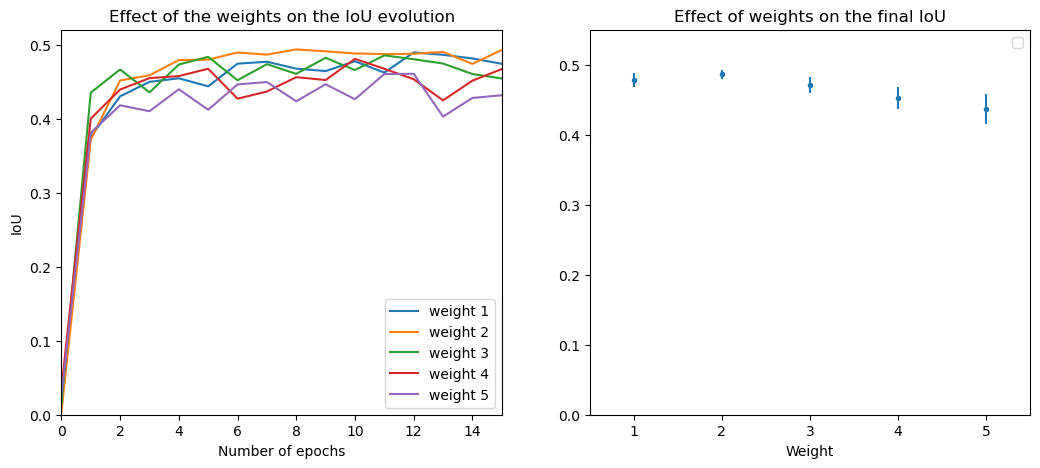

In [37]:
test_counter = np.linspace(0, n_epochs, n_epochs+1)

# Plot the fitting results as the loss function and the IoU

fig_dif_weights, axs = plt.subplots(1, 2, figsize=(12.5,5))

axs[0].set_title("Effect of the weights on the IoU evolution")
axs[0].plot(test_counter, IOU_all_arr[0], label='weight 1')
axs[0].plot(test_counter, IOU_all_arr[1], label='weight 2')
axs[0].plot(test_counter, IOU_all_arr[2], label='weight 3')
axs[0].plot(test_counter, IOU_all_arr[3], label='weight 4')
axs[0].plot(test_counter, IOU_all_arr[4], label='weight 5')
#axs[0].hlines(0.4070115627594698, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
axs[0].set_xlim(0,n_epochs)
axs[0].set_ylim(0,0.52)
axs[0].set_xlabel("Number of epochs")
axs[0].set_ylabel("IoU")
axs[0].legend()

axs[1].set_title("Effect of weights on the final IoU")
axs[1].errorbar(np.array([1,2,3,4,5]), np.mean(IOU_all_arr[:, -5:], axis=1), yerr=np.std(IOU_all_arr[:, -5:], axis=1), fmt='.')
#axs[1].hlines(0.4070115627594698, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
axs[1].set_xlabel("Weight")
#axs[1].set_ylabel("IoU")
axs[1].set_xlim(0.5, 5.5)
axs[1].legend()
axs[1].set_ylim(0,0.55)

plt.show()

fig_dif_weights.savefig("images/DiffWeights.pdf")
